### Room Occupancy Prediction EDA


In this visualization EDA we will concat all sensor data together to explore possible relation between data and occupancy.


In [1]:
# Use pandas to load the data
import pandas as pd
from sklearn.preprocessing import StandardScaler

training_path = "occupancy_data/datatraining.txt"
test_path = "occupancy_data/datatest.txt" 
test2_path = "occupancy_data/datatest2.txt"

In [2]:
# read data using pandas
train_data = pd.read_csv(training_path)
test_data = pd.read_csv(test_path)
test2_data = pd.read_csv(test2_path)

# convert date column to pandas datetime
train_data.date = pd.to_datetime(train_data.date)
test_data.date = pd.to_datetime(test_data.date)
test2_data.date = pd.to_datetime(test2_data.date)

In [3]:
# Checking for any Null value
print(train_data.isna().values.any())
print(test_data.isna().values.any())
print(test2_data.isna().values.any())

False
False
False


In [31]:


# Concat train, test and test2 data together, since we want to visualized EDA
total = pd.concat([train_data, test_data], axis=0)
total = pd.concat([total, test2_data], axis=0)

cols = total.columns.drop('date').drop('Occupancy')

# Resample sensor data for each day with mean, and count daily occupancy instances using sum
daily_mean_total = total.resample('1H', on='date').mean().reset_index()
daily_count_occu_total = total.resample('1H', on='date').sum().reset_index()['Occupancy']

daily_mean_date = daily_mean_total[['date', 'Occupancy']]

scaler = StandardScaler()

total_std = scaler.fit_transform(total[cols])
total_std = pd.DataFrame(total_std, columns=cols)

daily_total_std = scaler.fit_transform(daily_mean_total[cols])
daily_mean_total_std = pd.DataFrame(daily_total_std, columns=cols)
daily_mean_total_std = pd.concat([daily_mean_date, daily_mean_total_std], axis=1)
daily_mean_total_std.head()

,date,Occupancy,Temperature,Humidity,Light,CO2,HumidityRatio
0,2015-02-02 14:00:00,1.000000,2.591877,-0.130332,1.802744,0.662502,0.855629
1,2015-02-02 15:00:00,1.000000,2.248193,0.149644,1.589881,1.321968,1.040153
2,2015-02-02 16:00:00,1.000000,1.755325,-0.188046,1.482217,0.923128,0.458727
3,2015-02-02 17:00:00,0.610169,1.529504,-0.543951,1.442345,0.416585,-0.022486
4,2015-02-02 18:00:00,0.083333,1.017388,-0.619788,-0.495174,0.086975,-0.281581


In [57]:
# visualize feature correlations
import matplotlib.pyplot as plt

total_no_labels = total.drop('date', axis=1).drop('Occupancy', axis=1)

corr = total_std.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

,Temperature,Humidity,Light,CO2,HumidityRatio
Temperature,1,-0.157,0.6886,0.45,0.2053
Humidity,-0.157,1,-0.02946,0.2997,0.9327
Light,0.6886,-0.02946,1,0.4481,0.2233
CO2,0.45,0.2997,0.4481,1,0.478
HumidityRatio,0.2053,0.9327,0.2233,0.478,1


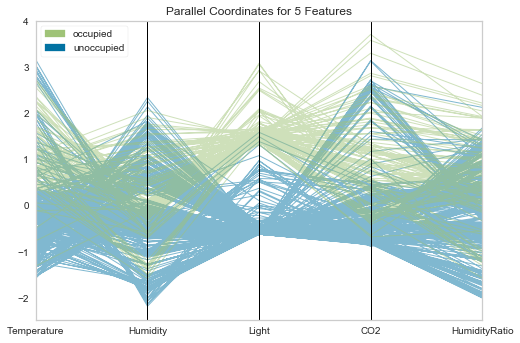

In [58]:
from yellowbrick.features import ParallelCoordinates

X, y = total_std, total['Occupancy']

features = X.columns
classes = ["unoccupied", "occupied"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, fast=True, sample=0.025, shuffle=True)

# Fit and transform the data to the visualizer
visualizer.fit_transform(X, y)

# Finalize the title and axes then display the visualization
visualizer.poof()

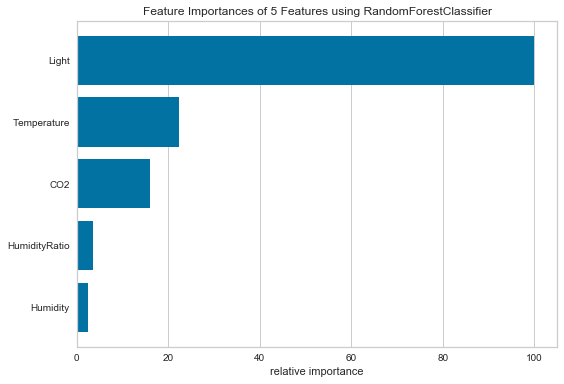

In [63]:
# Visualize Feature Importance
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(RandomForestClassifier(n_estimators=1500, n_jobs=-1), ax=ax)
viz.fit(X, y)
viz.poof()

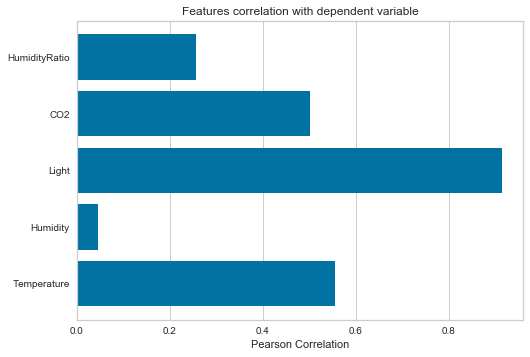

In [60]:
from yellowbrick.target import FeatureCorrelation

feature_names = X.columns
visualizer = FeatureCorrelation(labels=feature_names)
visualizer.fit(X, y)
visualizer.poof()

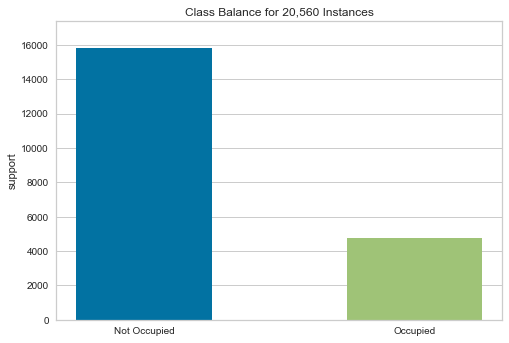

In [37]:
# Visualize Class balance
from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=['Not Occupied', 'Occupied'])
visualizer.fit(y)
visualizer.poof()

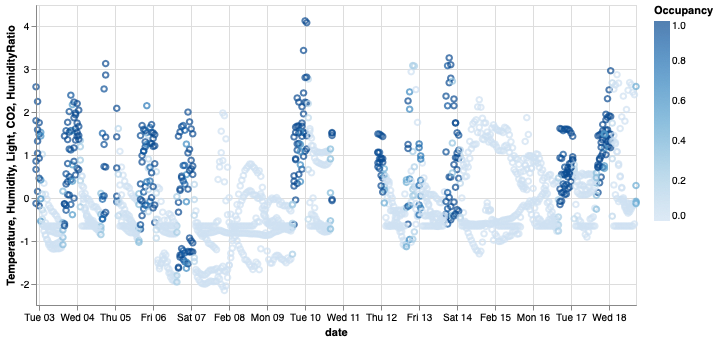

In [38]:
import altair as alt
from vega_datasets import data

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

base_t = alt.Chart(daily_mean_total_std, 
                   width=600).encode(x='date:T',
                                     y='Temperature:Q',
                                     color='Occupancy')


base_h = alt.Chart(daily_mean_total_std, 
                   width=600).encode(x='date:T',
                                     y='Humidity:Q',
                                     color='Occupancy')

base_l = alt.Chart(daily_mean_total_std, 
                   width=600).encode(x='date:T',
                                     y='Light:Q',
                                     color='Occupancy')

base_co2 = alt.Chart(daily_mean_total_std, 
                     width=600).encode(x='date:T',
                                       y='CO2:Q',
                                       color='Occupancy')

base_hr = alt.Chart(daily_mean_total_std, 
                    width=600).encode(x='date:T',
                                       y='HumidityRatio:Q',
                                       color='Occupancy')

base_t.mark_point() + base_h.mark_point() + base_l.mark_point() + base_co2.mark_point() + base_hr.mark_point()
